In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/flight_ticket_participant_datasets-20190305t100527z-001/Flight_Ticket_Participant_Datasets"))

# Any results you write to the current directory are saved as output.

['Test_set.xlsx', 'Sample_submission.xlsx', 'Data_Train.xlsx']


In [2]:
train1=pd.read_excel('../input/flight_ticket_participant_datasets-20190305t100527z-001/Flight_Ticket_Participant_Datasets/Data_Train.xlsx')
test1=pd.read_excel('../input/flight_ticket_participant_datasets-20190305t100527z-001/Flight_Ticket_Participant_Datasets/Test_set.xlsx')
s=pd.read_excel('../input/flight_ticket_participant_datasets-20190305t100527z-001/Flight_Ticket_Participant_Datasets/Sample_submission.xlsx')
train1.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
# train1
train1.iloc[6474, 7] = "24h 5m"
test1.iloc[2660, 7] = "24h 5m"

train1.iloc[1478, 0]
train1.iloc[2618, 0] = "Jet Airways Business"
train1.iloc[5439, 0] = "Jet Airways Business"
train1.drop(index = 2924, inplace = True, axis = 0)

In [4]:
print(train1[train1['Price']<=60000].shape)
print(train1.shape)
train=train1.copy()
train=train[train['Price']<=60000]
train.Additional_Info.replace(['No Info'], ['No info'], inplace=True)
train['Route'].fillna('DEL → COK',inplace=True)
train['Total_Stops'].fillna('non-stop',inplace=True)
train=train[~train['Additional_Info'].isin(['Red-eye flight','1 Short layover','2 Long layover'])]
train["Airline"]=train.Airline.replace("Trujet", "SpiceJet")
print(train.shape)



(10681, 11)
(10682, 11)
(10678, 11)


In [5]:
# train=train1.copy()
train.describe(include='all').T
# train['Airline'].value_counts()
# np.where(train["Airline"] == "Multiple carriers Premium economy", "Multiple carriers", train["Airline"])
# np.where(train['Airline']=='Jet Airways Business', 'High', 'Low')
train['Additional_Info'].value_counts()

No info                         8348
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     2
Name: Additional_Info, dtype: int64

In [6]:
train['Airline'].value_counts()

Jet Airways                          3847
IndiGo                               2053
Air India                            1750
Multiple carriers                    1196
SpiceJet                              819
Vistara                               479
Air Asia                              318
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Name: Airline, dtype: int64

In [7]:
test1.describe(include='all').T
# train['Airline'].value_counts()

,count,unique,top,freq
Airline,2671,11,Jet Airways,897
Date_of_Journey,2671,44,9/05/2019,144
Source,2671,5,Delhi,1145
Destination,2671,6,Cochin,1145
Route,2671,100,DEL → BOM → COK,624
Dep_Time,2671,199,10:00,62
Arrival_Time,2671,704,19:00,113
Duration,2671,319,2h 50m,122
Total_Stops,2671,5,1 stop,1431
Additional_Info,2671,6,No info,2148


In [8]:
# len(np.intersect1d(train['Duration'],test1['Duration']))
# np.setdiff1d(train['Duration'],test1['Duration'])

In [9]:
train=train[(train['Duration'].isin(test1['Duration'])) & (train['Route'].isin(test1['Route'])) & (train['Dep_Time'].isin(test1['Dep_Time'])) & (train['Arrival_Time'].isin(test1['Arrival_Time']))]

In [10]:
train.shape

(9001, 11)

In [11]:
train=pd.DataFrame(data=train.values,columns=train.columns).reset_index().drop('index',axis=1)

In [12]:
print(train.shape)
main_df=train.append(test1,ignore_index=True)

(9001, 11)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [13]:
main_df.reset_index().drop('index',axis=1,inplace=True)

In [14]:
main_df.Airline.value_counts()
main_df.replace({'New Delhi': 'Delhi'},inplace=True)

In [15]:
# main_df[((main_df.Arrival_Time>'18:00') & (main_df.Arrival_Time>'18:00') )& ((main_df.Dep_Time>'18:00') & (main_df.Dep_Time>'18:00'))]

In [16]:


# Banglore Kolkata 1,879 3
# 'Cochin Delhi', 2705 5

#        'Kolkata Chennai', 1676 2
#     'Delhi Banglore', 2157 4
#     'Hyderabad Mumbai' 711 1

# travelmap={'Banglore Kolkata':3, 'Cochin Delhi':5, 'Delhi Banglore':4,
#        'Kolkata Chennai':2, 'Hyderabad Mumbai':1}
# (main_df['Destination']+' '+main_df['Source']).replace(travelmap)

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer
def routeMap(val):
    val=val.split(" → ")
    val2=[i[:3] for i in val]
    return val2
def other_day_arr(val):
    if len(val.split(" "))>1:
        return 1
    else:
        return 0

def dura_hr(val):
    p=val.split(" ")[0]
    return int(p[:-1])

    
def dura_min(val):
    try:
        p=val.split(" ")[1]
    except:
        p='0h'
    return int(p[:-1])
def stop_count(val):
    if val=='non-stop':
        return 0
    else:
        return int(val.split(" ")[0])
    
def isweekday(v):
    if v in [5,6]:
        return 0
    else:
        return 1
    
def ismultiple(v):
    if v in ['Multiple carriers Premium economy','Multiple carriers']:
        return 1
    else:
        return 0
def isprem(v):
    if v.find('Premium')!=-1:
        return 1
    else:
        return 0
    
def time_bins(v):
    if v>='00:00' and v<'06:00':
        return 'Morning'
    elif v>='06:00' and v<'12:00':
        return 'Afternoon'
    elif v>='12:00' and v<'18:00':
        return 'Evening'
    elif v>='18:00' and v<='23:60':
        return 'Night'
    else:
        return 'Else'
    
df=main_df.copy()
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
df['day']=df['Date_of_Journey'].dt.day.astype(str)
df['month']=df['Date_of_Journey'].dt.month.astype(str)
df['week']=df['Date_of_Journey'].dt.week.astype(str)
df['weekday']=df['Date_of_Journey'].dt.weekday.astype(str)
df['isweekday']=df['Date_of_Journey'].dt.weekday.apply(isweekday)

df['Dest_Source']=df['Destination']+' '+df['Source']
print(df['Dest_Source'].unique())
# df['travel_mp']=df['Dest_Source'].replace(travelmap)
df['ismultipleCarr']=df['Airline'].apply(ismultiple)
df['isprem']=df['Airline'].apply(isprem)
df['Route_stops']=df['Route'].astype(str).apply(lambda x :len(x.split(" → ")))
df['dep_time_hour']=pd.to_datetime(df['Dep_Time']).dt.hour.astype(str)
df['dep_time_sec']=pd.to_datetime(df['Dep_Time']).dt.minute.astype(str)

df['arr_time_bins']=df['Arrival_Time'].apply(time_bins)
df['dept_time_bins']=df['Dep_Time'].apply(time_bins)
df['arr_time_hour']=pd.to_datetime(df['Arrival_Time']).dt.hour.astype(str)
df['arr_time_sec']=pd.to_datetime(df['Arrival_Time']).dt.minute.astype(str)
df['arr_next_day']=df['Arrival_Time'].apply(other_day_arr)
# df['dur_min']=df['Duration'].apply(dura_min)
# df['dur_hr']=df['Duration'].apply(dura_hr)

df['Total_Stops'].fillna('non-stop',inplace=True)
df['stop_count']=df['Total_Stops'].apply(stop_count)
df["class"] = np.where(df['Airline']=='Jet Airways Business', 'High', 'Low')
df["meal"] = np.where(df['Additional_Info']=='In-flight meal not included', 'High', 'Low')
df["checkin"] = np.where(df['Additional_Info']=='No check-in baggage included', 'High', 'Low')
print(df.columns)


tr_route=df[df['Price'].isnull()==False]['Route'].apply(lambda x: " ".join(str(x).split(" → ")))
ts_route=df[df['Price'].isnull()==True]['Route'].apply(lambda x: " ".join(str(x).split(" → ")))
df['total']=df['Airline']+' '+df['Source']+' '+df['Destination']+' '+df['Total_Stops']+' '+df['Additional_Info']
add_info_tr=df[df['Price'].isnull()==False]['total'].values
add_info_ts=df[df['Price'].isnull()==True]['total'].values
df.drop(['total'],axis=1,inplace=True)

import seaborn as sns

# sns.heatmap(df[df['Price'].isnull()==False].corr())


df=pd.get_dummies(df,columns=['Date_of_Journey','Additional_Info', 'Airline', 'Destination', 'Duration', 'Route', 'Source','Dest_Source',
       'Total_Stops','Route_stops','arr_time_bins','dept_time_bins','weekday','class','meal','checkin','month','day','week','dep_time_hour','dep_time_sec'
                             ,'arr_time_hour','arr_time_sec'],drop_first=True)
# df.drop(['Date_of_Journey','Dep_Time','Duration','Arrival_Time','Total_Stops'],axis=1,inplace=True)
# ['Additional_Info', 'Airline', 'Arrival_Time', 
#        'Dep_Time', 'Destination', 'Duration', 'Route', 'Source',
#        'Total_Stops','Route_stops']
df.drop(['Dep_Time','Arrival_Time'],axis=1,inplace=True)
df['Price']




# from sklearn.preprocessing import MultiLabelBinarizer
# m=MultiLabelBinarizer()
# route_bin=pd.DataFrame(data=m.fit_transform(main_df['Route'].astype(str).apply(routeMap)),columns=m.classes_)
# merged = df.merge(route_bin, how='inner',left_index=True, right_index=True)
# merged.head()
# merged.drop(['Route'],axis=1,inplace=True)


df.head()

['Banglore Kolkata' 'Cochin Delhi' 'Delhi Banglore' 'Kolkata Chennai'
 'Hyderabad Mumbai']
Index(['Additional_Info', 'Airline', 'Arrival_Time', 'Date_of_Journey',
       'Dep_Time', 'Destination', 'Duration', 'Price', 'Route', 'Source',
       'Total_Stops', 'day', 'month', 'week', 'weekday', 'isweekday',
       'Dest_Source', 'ismultipleCarr', 'isprem', 'Route_stops',
       'dep_time_hour', 'dep_time_sec', 'arr_time_bins', 'dept_time_bins',
       'arr_time_hour', 'arr_time_sec', 'arr_next_day', 'stop_count', 'class',
       'meal', 'checkin'],
      dtype='object')


,Price,isweekday,ismultipleCarr,isprem,arr_next_day,stop_count,Date_of_Journey_2019-01-04 00:00:00,Date_of_Journey_2019-01-05 00:00:00,Date_of_Journey_2019-01-06 00:00:00,Date_of_Journey_2019-03-03 00:00:00,Date_of_Journey_2019-03-04 00:00:00,Date_of_Journey_2019-03-05 00:00:00,Date_of_Journey_2019-03-06 00:00:00,Date_of_Journey_2019-03-15 00:00:00,Date_of_Journey_2019-03-18 00:00:00,Date_of_Journey_2019-03-21 00:00:00,Date_of_Journey_2019-03-24 00:00:00,Date_of_Journey_2019-03-27 00:00:00,Date_of_Journey_2019-04-15 00:00:00,Date_of_Journey_2019-04-18 00:00:00,Date_of_Journey_2019-04-21 00:00:00,Date_of_Journey_2019-04-24 00:00:00,Date_of_Journey_2019-04-27 00:00:00,Date_of_Journey_2019-05-15 00:00:00,Date_of_Journey_2019-05-18 00:00:00,Date_of_Journey_2019-05-21 00:00:00,Date_of_Journey_2019-05-24 00:00:00,Date_of_Journey_2019-05-27 00:00:00,Date_of_Journey_2019-06-03 00:00:00,Date_of_Journey_2019-06-04 00:00:00,Date_of_Journey_2019-06-05 00:00:00,Date_of_Journey_2019-06-06 00:00:00,Date_of_Journey_2019-06-15 00:00:00,Date_of_Journey_2019-06-18 00:00:00,Date_of_Journey_2019-06-21 00:00:00,Date_of_Journey_2019-06-24 00:00:00,Date_of_Journey_2019-06-27 00:00:00,Date_of_Journey_2019-09-03 00:00:00,Date_of_Journey_2019-09-04 00:00:00,Date_of_Journey_2019-09-05 00:00:00,...,dep_time_sec_35,dep_time_sec_40,dep_time_sec_45,dep_time_sec_5,dep_time_sec_50,dep_time_sec_55,arr_time_hour_1,arr_time_hour_10,arr_time_hour_11,arr_time_hour_12,arr_time_hour_13,arr_time_hour_14,arr_time_hour_15,arr_time_hour_16,arr_time_hour_17,arr_time_hour_18,arr_time_hour_19,arr_time_hour_2,arr_time_hour_20,arr_time_hour_21,arr_time_hour_22,arr_time_hour_23,arr_time_hour_3,arr_time_hour_4,arr_time_hour_5,arr_time_hour_6,arr_time_hour_7,arr_time_hour_8,arr_time_hour_9,arr_time_sec_10,arr_time_sec_15,arr_time_sec_20,arr_time_sec_25,arr_time_sec_30,arr_time_sec_35,arr_time_sec_40,arr_time_sec_45,arr_time_sec_5,arr_time_sec_50,arr_time_sec_55
0,7662.0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,13882.0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,6218.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,13302.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3873.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [18]:
df_train = df[df['Price'].isnull()==False]
df_test = df[df['Price'].isnull()==True]
# df_test = df_test.drop(['Price'], axis =1)
print(df_train.shape,df_test.shape)

(9001, 610) (2671, 610)


In [19]:
df['meal_Low'].value_counts()
# df.head()

1    9493
0    2179
Name: meal_Low, dtype: int64

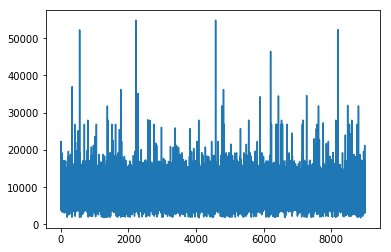

In [20]:
# df_train = merged[merged['Price'].isnull()==False]
# df_test = merged[merged['Price'].isnull()==True]
# # df_test = df_test.drop(['Price'], axis =1)
# print(df_train.shape,df_test.shape)
import matplotlib.pyplot as plt
%matplotlib inline
df_train['Price'].plot()

In [21]:
# main_df
# maindf_train = main_df[main_df['Price'].isnull()==False].drop(['Price'],axis=1)
# maindf_test = main_df[main_df['Price'].isnull()==True].drop(['Price'],axis=1)
# # maindf_test = maindf_test.drop(['Price'], axis =1)
# y=main_df[main_df['Price'].isnull()==False]['Price'].astype(np.float64)
# print(maindf_train.shape,maindf_test.shape)

In [22]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vec_cr = TfidfVectorizer(ngram_range=(1,1),stop_words="english", analyzer='word')
v_train =vec_cr.fit_transform(tr_route)
v_test =vec_cr.transform(ts_route)

# vect_cr = TfidfVectorizer(ngram_range=(1,1),stop_words="english", analyzer='word')
# vt_train =vec_cr.fit_transform(tr_route)
# vt_test =vec_cr.transform(ts_route)

vec_char = TfidfVectorizer(ngram_range=(1,7),stop_words="english", analyzer='char')
v_trainC =vec_char.fit_transform(tr_route)
v_testC =vec_char.transform(ts_route)


vec_ad = TfidfVectorizer(ngram_range=(1,7),stop_words="english", analyzer='word')
vad_train =vec_ad.fit_transform(add_info_tr)
vad_test =vec_ad.transform(add_info_ts)

# vec_adC = TfidfVectorizer(ngram_range=(3,16),stop_words="english", analyzer='char')
# vad_trainC =vec_adC.fit_transform(add_info_tr)
# vad_testC =vec_adC.transform(add_info_ts)

In [23]:
# vect_cr.vocabulary_
# v_testC

In [24]:
v_test

<2671x37 sparse matrix of type '<class 'numpy.float64'>'
	with 7567 stored elements in Compressed Sparse Row format>

In [25]:
df_train.head()

,Price,isweekday,ismultipleCarr,isprem,arr_next_day,stop_count,Date_of_Journey_2019-01-04 00:00:00,Date_of_Journey_2019-01-05 00:00:00,Date_of_Journey_2019-01-06 00:00:00,Date_of_Journey_2019-03-03 00:00:00,Date_of_Journey_2019-03-04 00:00:00,Date_of_Journey_2019-03-05 00:00:00,Date_of_Journey_2019-03-06 00:00:00,Date_of_Journey_2019-03-15 00:00:00,Date_of_Journey_2019-03-18 00:00:00,Date_of_Journey_2019-03-21 00:00:00,Date_of_Journey_2019-03-24 00:00:00,Date_of_Journey_2019-03-27 00:00:00,Date_of_Journey_2019-04-15 00:00:00,Date_of_Journey_2019-04-18 00:00:00,Date_of_Journey_2019-04-21 00:00:00,Date_of_Journey_2019-04-24 00:00:00,Date_of_Journey_2019-04-27 00:00:00,Date_of_Journey_2019-05-15 00:00:00,Date_of_Journey_2019-05-18 00:00:00,Date_of_Journey_2019-05-21 00:00:00,Date_of_Journey_2019-05-24 00:00:00,Date_of_Journey_2019-05-27 00:00:00,Date_of_Journey_2019-06-03 00:00:00,Date_of_Journey_2019-06-04 00:00:00,Date_of_Journey_2019-06-05 00:00:00,Date_of_Journey_2019-06-06 00:00:00,Date_of_Journey_2019-06-15 00:00:00,Date_of_Journey_2019-06-18 00:00:00,Date_of_Journey_2019-06-21 00:00:00,Date_of_Journey_2019-06-24 00:00:00,Date_of_Journey_2019-06-27 00:00:00,Date_of_Journey_2019-09-03 00:00:00,Date_of_Journey_2019-09-04 00:00:00,Date_of_Journey_2019-09-05 00:00:00,...,dep_time_sec_35,dep_time_sec_40,dep_time_sec_45,dep_time_sec_5,dep_time_sec_50,dep_time_sec_55,arr_time_hour_1,arr_time_hour_10,arr_time_hour_11,arr_time_hour_12,arr_time_hour_13,arr_time_hour_14,arr_time_hour_15,arr_time_hour_16,arr_time_hour_17,arr_time_hour_18,arr_time_hour_19,arr_time_hour_2,arr_time_hour_20,arr_time_hour_21,arr_time_hour_22,arr_time_hour_23,arr_time_hour_3,arr_time_hour_4,arr_time_hour_5,arr_time_hour_6,arr_time_hour_7,arr_time_hour_8,arr_time_hour_9,arr_time_sec_10,arr_time_sec_15,arr_time_sec_20,arr_time_sec_25,arr_time_sec_30,arr_time_sec_35,arr_time_sec_40,arr_time_sec_45,arr_time_sec_5,arr_time_sec_50,arr_time_sec_55
0,7662.0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,13882.0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,6218.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,13302.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3873.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [26]:
df_train.drop(['Price'],axis=1).shape

(9001, 609)

In [27]:
print(df_train.shape,df_test.shape)

(9001, 610) (2671, 610)


In [28]:
from scipy.sparse import csr_matrix
from scipy import sparse
final_features = sparse.hstack((df_train.drop(['Price'],axis=1), v_train,v_trainC,vad_train)).tocsr()
final_features1 = sparse.hstack((df_test.drop(['Price'],axis=1), v_test,v_testC,vad_test)).tocsr()

In [29]:
final_features
# from sklearn.decomposition import TruncatedSVD
# t=TruncatedSVD(n_components=1000)
# fftr=t.fit_transform(final_features)

<9001x3250 sparse matrix of type '<class 'numpy.float64'>'
	with 870117 stored elements in Compressed Sparse Row format>

In [30]:
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score,f1_score,mean_squared_error,mean_squared_log_error
X=final_features
y=np.log1p(df_train['Price'].astype(np.float64))
# y=train['Fees']
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.25,random_state = 1994)

In [31]:
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge,RidgeCV,BayesianRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_log_error
import math
def rmsle(real, predicted):
    real=np.expm1(real)
    predicted=np.expm1(predicted)
    return np.sqrt(mean_squared_log_error(real,predicted))
    
def rmsle_lgb(labels, preds):
    return 'rmsle', rmsle(preds,labels), False

In [32]:
# from sklearn.decomposition import TruncatedSVD
# t=TruncatedSVD(n_components=200)
# xtr=t.fit_transform(X_train)
# xts=t.transform(X_val)
from xgboost import XGBRegressor
# m=XGBRegressor(n_estimators=6000,learning_rate=0.03,random_state=1994)
# # m=RidgeCV(cv=4)
# m.fit(X_train,y_train,eval_set=[(X_val, y_val.values)],eval_metric='rmse', early_stopping_rounds=100,verbose=100)
# p1=m.predict(X_val)
# # m=Rid
# # print(np.sqrt(mean_squared_log_error(np.expm1(y_val.values),np.expm1(p))))
# # print(np.sqrt(mean_squared_log_error(y_val.values,p)))
# print(rmsle_lgb(y_val.values,p1))

In [33]:

m=LGBMRegressor(n_estimators=4000,learning_rate=0.05,random_state=1994)
# m=RidgeCV(cv=4)
m.fit(X_train,y_train,eval_set=[(X_val, y_val.values)],eval_metric=rmsle_lgb, early_stopping_rounds=100,verbose=100)
p=m.predict(X_val)
# m=Rid
# print(np.sqrt(mean_squared_log_error(np.expm1(y_val.values),np.expm1(p))))
# print(np.sqrt(mean_squared_log_error(y_val.values,p)))
print(rmsle_lgb(y_val.values,p))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l2: 0.0177079	valid_0's rmsle: 0.133071
[200]	valid_0's l2: 0.0144309	valid_0's rmsle: 0.120129
[300]	valid_0's l2: 0.0132813	valid_0's rmsle: 0.115245
[400]	valid_0's l2: 0.0127462	valid_0's rmsle: 0.112899
[500]	valid_0's l2: 0.0124314	valid_0's rmsle: 0.111496
[600]	valid_0's l2: 0.0122731	valid_0's rmsle: 0.110784
[700]	valid_0's l2: 0.0121691	valid_0's rmsle: 0.110314
[800]	valid_0's l2: 0.0120474	valid_0's rmsle: 0.109761
[900]	valid_0's l2: 0.0119589	valid_0's rmsle: 0.109357
[1000]	valid_0's l2: 0.0119	valid_0's rmsle: 0.109087
[1100]	valid_0's l2: 0.0118324	valid_0's rmsle: 0.108777
[1200]	valid_0's l2: 0.0117947	valid_0's rmsle: 0.108604
Early stopping, best iteration is:
[1195]	valid_0's l2: 0.0117896	valid_0's rmsle: 0.10858
('rmsle', 0.10858005865644464, False)


In [34]:
# from sklearn_pandas import DataFrameMapper, FunctionTransformer, CategoricalImputer
# from sklearn.preprocessing import LabelEncoder, LabelBinarizer, KBinsDiscretizer
# from sklearn.impute import SimpleImputer
# from sklearn.base import TransformerMixin

# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import StratifiedShuffleSplit

# import xgboost as xgb
# import lightgbm as lgb
# from sklearn.ensemble import GradientBoostingRegressor

# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb
# lgbm_model = lgb.LGBMRegressor()
# lgbm_model.fit(X_train.astype(float), y_train.astype(float))

# print( np.sqrt( -cross_val_score(lgbm_model, X_train.astype(float), y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
# np.sqrt(mean_squared_error(y_val, lgbm_model.predict(X_val)))

In [35]:
# lgbm_engine = lgb.LGBMRegressor()
# lgbm_params = {'max_depth' : [7,9], 'learning_rate' : [ 0.1,0.05], 'n_estimators': [2000]}

# lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 5, n_jobs = -1, verbose = 1)
# lgbm_grid.fit(X_train, y_train)
# print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
# print( np.sqrt( mean_squared_error(y_val, lgbm_grid.predict(X_val)) ) )

In [36]:
# # for a, b, c in zip( lgbm_grid.cv_results_['params'], lgbm_grid.cv_results_['mean_test_score'], lgbm_grid.cv_results_['mean_train_score'] ):
# #     print(a, b, c)

# base_model = xgb.XGBRegressor(learning_rate=0.05)
# base_model.fit(X_train, y_train)
# print( np.sqrt( -cross_val_score(base_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )

In [37]:
# xgb_engine = xgb.XGBRegressor(n_estimator=2000) #n_estimator not used
# xgb_params = {'max_depth' : np.arange(5, 12, 3), 'gamma' : [0.01, 1], 'learning_rate' : [0.1, 0.02, 0.05]}

# xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = 5, n_jobs = -1, verbose = 1)
# xgb_grid.fit(X_train, y_train)

# print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )

In [38]:
# from mlxtend.regressor import StackingRegressor
# from mlxtend.data import boston_housing_data
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.svm import SVR
# import matplotlib.pyplot as plt
# import numpy as np



# lgb = LGBMRegressor(n_estimators=4000,learning_rate=0.05,random_state=1994)
# rf = RandomForestRegressor(n_estimators=100)
# xgb=XGBRegressor(n_estimators=4000,learning_rate=0.05,random_state=1994)
# # ridge = Ridge(random_state=1)
# # svr_rbf = SVR(kernel='rbf')

# stregr = StackingRegressor(regressors=[rf,xgb ,rf,xgb], 
#                            meta_regressor=lgb,use_features_in_secondary=False,verbose=1)

# # Training the stacking classifier
# stregr.fit(X_train,y_train)
# p3=stregr.predict(X_val)
# # m=Rid
# # print(np.sqrt(mean_squared_log_error(np.expm1(y_val.values),np.expm1(p))))
# # print(np.sqrt(mean_squared_log_error(y_val.values,p)))
# print(rmsle_lgb(y_val.values,p3))

In [39]:
from sklearn.ensemble import RandomForestRegressor
m=RandomForestRegressor(n_estimators=150)
# m=RidgeCV(cv=4)
m.fit(X_train,y_train)
p2=m.predict(X_val)
# m=Rid
# print(np.sqrt(mean_squared_log_error(np.expm1(y_val.values),np.expm1(p))))
# print(np.sqrt(mean_squared_log_error(y_val.values,p)))
print(rmsle_lgb(y_val.values,p2))

('rmsle', 0.11600202146263613, False)


In [40]:
print(rmsle_lgb(y_val,(p*0.7+p2*0.3)))
print(rmsle_lgb(y_val,(p+p2)/2))

('rmsle', 0.1066030725794744, False)
('rmsle', 0.10733733652768601, False)


In [41]:
# m=RidgeCV(cv=5,random_state=1994)
# # m=RidgeCV(cv=4)
# m.fit(X_train,y_train,eval_set=[(X_val, y_val.values)],eval_metric=rmsle_lgb, early_stopping_rounds=100,verbose=100)
# p=m.predict(X_val)
# # m=Rid
# # print(np.sqrt(mean_squared_log_error(np.expm1(y_val.values),np.expm1(p))))
# # print(np.sqrt(mean_squared_log_error(y_val.values,p)))
# print(rmsle_lgb(y_val.values,p))

In [42]:
errlgb=[]
y_pred_totlgb=[]
i=0
from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=25,shuffle=True,random_state=1994)
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lgbm_params = {'n_estimators': 4000,
                   'n_jobs': -1,'learning_rate':0.01,'random_state':1994}
    rf=LGBMRegressor(**lgbm_params)
    rf.fit(X_train,y_train,eval_set=[(X_test, y_test.values)],
         eval_metric=rmsle_lgb,
#            eval_metric='rmse',
#            categorical_feature=cat_cols,
         verbose=200
         , early_stopping_rounds=100
          )
    pr=rf.predict(X_test)
    print("errlgb: ",rmsle_lgb(y_test.values,pr)[1])
    
    errlgb.append(rmsle_lgb(y_test.values,pr)[1])
    p = rf.predict(final_features1)
    y_pred_totlgb.append(p)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.0300177	valid_0's rmsle: 0.173256
[400]	valid_0's l2: 0.0194563	valid_0's rmsle: 0.139486
[600]	valid_0's l2: 0.0163642	valid_0's rmsle: 0.127923
[800]	valid_0's l2: 0.0150456	valid_0's rmsle: 0.12266
[1000]	valid_0's l2: 0.0141567	valid_0's rmsle: 0.118982
[1200]	valid_0's l2: 0.0133958	valid_0's rmsle: 0.11574
[1400]	valid_0's l2: 0.0128793	valid_0's rmsle: 0.113487
[1600]	valid_0's l2: 0.0124617	valid_0's rmsle: 0.111632
[1800]	valid_0's l2: 0.0122225	valid_0's rmsle: 0.110555
[2000]	valid_0's l2: 0.0120343	valid_0's rmsle: 0.109701
[2200]	valid_0's l2: 0.0118523	valid_0's rmsle: 0.108868
[2400]	valid_0's l2: 0.0116394	valid_0's rmsle: 0.107886
[2600]	valid_0's l2: 0.0115039	valid_0's rmsle: 0.107256
[2800]	valid_0's l2: 0.0113922	valid_0's rmsle: 0.106734
[3000]	valid_0's l2: 0.0112937	valid_0's rmsle: 0.106272
[3200]	valid_0's l2: 0.011219	valid_0's rmsle: 0.10592
[3400]	valid_0's l2: 0.0111744	va

In [43]:
errxgb=[]
y_pred_totxgb=[]
i=0
from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=25,shuffle=True,random_state=1994)
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    lgbm_params = {'n_estimators': 6000,
                   'n_jobs': -1}
    rf=XGBRegressor(**lgbm_params)
    rf.fit(X_train,y_train,eval_set=[(X_test, y_test.values)],
#          eval_metric=rmsle_lgb,
           eval_metric='rmse',
#            categorical_feature=cat_cols,
         verbose=200
         , early_stopping_rounds=100
          )
    pr=rf.predict(X_test)
    print("errxgb: ",rmsle_lgb(y_test.values,pr)[1])
    
    errxgb.append(rmsle_lgb(y_test.values,pr)[1])
    p = rf.predict(final_features1)
    y_pred_totxgb.append(p)

[0]	validation_0-rmse:7.61544
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.144907
[400]	validation_0-rmse:0.133399
[600]	validation_0-rmse:0.128017
[800]	validation_0-rmse:0.12485
[1000]	validation_0-rmse:0.123119
[1200]	validation_0-rmse:0.122029
[1400]	validation_0-rmse:0.120544
[1600]	validation_0-rmse:0.120307
Stopping. Best iteration:
[1677]	validation_0-rmse:0.120034

errxgb:  0.1200340696914804
[0]	validation_0-rmse:7.66473
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.140424
[400]	validation_0-rmse:0.129019
[600]	validation_0-rmse:0.123997
[800]	validation_0-rmse:0.120387
[1000]	validation_0-rmse:0.119527
[1200]	validation_0-rmse:0.11814
[1400]	validation_0-rmse:0.117691
[1600]	validation_0-rmse:0.116404
Stopping. Best iteration:
[1633]	validation_0-rmse:0.116254

errxgb:  0.11625390269452404
[0]	validation_0-rmse:7.64937
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.132124
[400]	validation_0-rmse:0.118586
[600]	validation_0-rmse:0.111966
[800]	validation_0-rmse:0.109207
[1000]	validation_0-rmse:0.10657
[1200]	validation_0-rmse:0.105264
[1400]	validation_0-rmse:0.104546
[1600]	validation_0-rmse:0.103355
Stopping. Best iteration:
[1585]	validation_0-rmse:0.103184

errxgb:  0.1031843755464814
[0]	validation_0-rmse:7.61634
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.155213
[400]	validation_0-rmse:0.139786
[600]	validation_0-rmse:0.131372
[800]	validation_0-rmse:0.127099
[1000]	validation_0-rmse:0.123528
[1200]	validation_0-rmse:0.122144
[1400]	validation_0-rmse:0.119349
[1600]	validation_0-rmse:0.118409
[1800]	validation_0-rmse:0.117042
[2000]	validation_0-rmse:0.116181
[2200]	validation_0-rmse:0.114929
[2400]	validation_0-rmse:0.114198
[2600]	validation_0-rmse:0.113396
[2800]	validation_0-rmse:0.112935
[3000]	validation_0-rmse:0.112165
[3200]	validation_0-rmse:0.111632
[3400]	validation_0-rmse:0.110123
[3600]	validation_0-rmse:0.109605
Stopping. Best iteration:
[3506]	validation_0-rmse:0.109539

errxgb:  0.10953913629509618
[0]	validation_0-rmse:7.6698
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.157371
[400]	validation_0-rmse:0.147418
[600]	validation_0-rmse:0.141794
[800]	validation_0-rmse:0.138606
[1000]	validation_0-rmse:0.136552
[1200]	validation_0-rmse:0.134907
[1400]	validation_0-rmse:0.133378
[1600]	validation_0-rmse:0.132037
[1800]	validation_0-rmse:0.130805
[2000]	validation_0-rmse:0.129623
[2200]	validation_0-rmse:0.128662
[2400]	validation_0-rmse:0.127784
[2600]	validation_0-rmse:0.126946
[2800]	validation_0-rmse:0.125764
[3000]	validation_0-rmse:0.125453
Stopping. Best iteration:
[2932]	validation_0-rmse:0.125289

errxgb:  0.1252887746976774
[0]	validation_0-rmse:7.67325
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.14289
[400]	validation_0-rmse:0.129164
[600]	validation_0-rmse:0.122173
[800]	validation_0-rmse:0.11787
[1000]	validation_0-rmse:0.114929
[1200]	validation_0-rmse:0.112442
[1400]	validation_0-rmse:0.111422
[1600]	validation_0-rmse:0.110572
[1800]	validation_0-rmse:0.109442
[2000]	validation_0-rmse:0.107829
[2200]	validation_0-rmse:0.106246
[2400]	validation_0-rmse:0.105271
[2600]	validation_0-rmse:0.104611
[2800]	validation_0-rmse:0.103972
[3000]	validation_0-rmse:0.103384
Stopping. Best iteration:
[3012]	validation_0-rmse:0.103272

errxgb:  0.10327149998974137
[0]	validation_0-rmse:7.6492
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.152291
[400]	validation_0-rmse:0.138411
[600]	validation_0-rmse:0.13175
[800]	validation_0-rmse:0.127796
[1000]	validation_0-rmse:0.125206
[1200]	validation_0-rmse:0.122547
[1400]	validation_0-rmse:0.121239
[1600]	validation_0-rmse:0.117756
[1800]	validation_0-rmse:0.116381
[2000]	validation_0-rmse:0.115139
[2200]	validation_0-rmse:0.113111
[2400]	validation_0-rmse:0.112713
[2600]	validation_0-rmse:0.112587
Stopping. Best iteration:
[2698]	validation_0-rmse:0.111849

errxgb:  0.11184900944987251
[0]	validation_0-rmse:7.61904
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.138053
[400]	validation_0-rmse:0.125185
[600]	validation_0-rmse:0.118776
[800]	validation_0-rmse:0.114503
[1000]	validation_0-rmse:0.112168
[1200]	validation_0-rmse:0.11084
[1400]	validation_0-rmse:0.110293
Stopping. Best iteration:
[1331]	validation_0-rmse:0.110003

errxgb:  0.11000297080658311
[0]	validation_0-rmse:7.61983
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.151993
[400]	validation_0-rmse:0.140748
[600]	validation_0-rmse:0.135148
[800]	validation_0-rmse:0.131967
[1000]	validation_0-rmse:0.130206
[1200]	validation_0-rmse:0.129028
[1400]	validation_0-rmse:0.127792
[1600]	validation_0-rmse:0.126546
[1800]	validation_0-rmse:0.125025
[2000]	validation_0-rmse:0.124392
Stopping. Best iteration:
[1942]	validation_0-rmse:0.124235

errxgb:  0.12423554577163953
[0]	validation_0-rmse:7.61363
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.150299
[400]	validation_0-rmse:0.133519
[600]	validation_0-rmse:0.124968
[800]	validation_0-rmse:0.121272
[1000]	validation_0-rmse:0.119117
[1200]	validation_0-rmse:0.117158
[1400]	validation_0-rmse:0.115724
[1600]	validation_0-rmse:0.114727
[1800]	validation_0-rmse:0.112823
Stopping. Best iteration:
[1852]	validation_0-rmse:0.112601

errxgb:  0.11260119392491767
[0]	validation_0-rmse:7.63104
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.147606
[400]	validation_0-rmse:0.135317
[600]	validation_0-rmse:0.130039
[800]	validation_0-rmse:0.12674
[1000]	validation_0-rmse:0.125161
[1200]	validation_0-rmse:0.123955
[1400]	validation_0-rmse:0.123455
[1600]	validation_0-rmse:0.121932
[1800]	validation_0-rmse:0.120243
Stopping. Best iteration:
[1886]	validation_0-rmse:0.11937

errxgb:  0.11936970986368661
[0]	validation_0-rmse:7.62441
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.148972
[400]	validation_0-rmse:0.133852
[600]	validation_0-rmse:0.126917
[800]	validation_0-rmse:0.122711
[1000]	validation_0-rmse:0.119162
[1200]	validation_0-rmse:0.116781
[1400]	validation_0-rmse:0.114614
[1600]	validation_0-rmse:0.112487
[1800]	validation_0-rmse:0.110726
[2000]	validation_0-rmse:0.108385
[2200]	validation_0-rmse:0.107023
[2400]	validation_0-rmse:0.105432
[2600]	validation_0-rmse:0.104966
[2800]	validation_0-rmse:0.104337
[3000]	validation_0-rmse:0.103823
[3200]	validation_0-rmse:0.103387
Stopping. Best iteration:
[3286]	validation_0-rmse:0.102957

errxgb:  0.10295693378824597
[0]	validation_0-rmse:7.64778
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.163736
[400]	validation_0-rmse:0.150025
[600]	validation_0-rmse:0.144328
[800]	validation_0-rmse:0.140203
[1000]	validation_0-rmse:0.138439
[1200]	validation_0-rmse:0.136597
[1400]	validation_0-rmse:0.135765
Stopping. Best iteration:
[1379]	validation_0-rmse:0.135471

errxgb:  0.13547033544172657
[0]	validation_0-rmse:7.66682
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.156069
[400]	validation_0-rmse:0.14313
[600]	validation_0-rmse:0.136012
[800]	validation_0-rmse:0.131578
[1000]	validation_0-rmse:0.129225
[1200]	validation_0-rmse:0.127891
[1400]	validation_0-rmse:0.126808
[1600]	validation_0-rmse:0.12536
[1800]	validation_0-rmse:0.124378
[2000]	validation_0-rmse:0.12326
[2200]	validation_0-rmse:0.123039
[2400]	validation_0-rmse:0.122216
Stopping. Best iteration:
[2471]	validation_0-rmse:0.121935

errxgb:  0.12193579238273287
[0]	validation_0-rmse:7.67744
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.156004
[400]	validation_0-rmse:0.13931
[600]	validation_0-rmse:0.131957
[800]	validation_0-rmse:0.128892
[1000]	validation_0-rmse:0.127125
[1200]	validation_0-rmse:0.125342
[1400]	validation_0-rmse:0.123974
[1600]	validation_0-rmse:0.123456
Stopping. Best iteration:
[1580]	validation_0-rmse:0.122903

errxgb:  0.12290294251465987
[0]	validation_0-rmse:7.6484
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.157806
[400]	validation_0-rmse:0.14508
[600]	validation_0-rmse:0.139121
[800]	validation_0-rmse:0.134842
[1000]	validation_0-rmse:0.13202
[1200]	validation_0-rmse:0.129735
[1400]	validation_0-rmse:0.129057
[1600]	validation_0-rmse:0.126878
[1800]	validation_0-rmse:0.125462
[2000]	validation_0-rmse:0.124072
[2200]	validation_0-rmse:0.122573
[2400]	validation_0-rmse:0.121336
[2600]	validation_0-rmse:0.120195
[2800]	validation_0-rmse:0.119705
[3000]	validation_0-rmse:0.119191
[3200]	validation_0-rmse:0.118951
[3400]	validation_0-rmse:0.11824
[3600]	validation_0-rmse:0.117282
Stopping. Best iteration:
[3550]	validation_0-rmse:0.11693

errxgb:  0.11693011793196274
[0]	validation_0-rmse:7.66386
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.153762
[400]	validation_0-rmse:0.140144
[600]	validation_0-rmse:0.133558
[800]	validation_0-rmse:0.129347
[1000]	validation_0-rmse:0.128101
[1200]	validation_0-rmse:0.126858
[1400]	validation_0-rmse:0.126125
[1600]	validation_0-rmse:0.125146
[1800]	validation_0-rmse:0.124819
Stopping. Best iteration:
[1723]	validation_0-rmse:0.124716

errxgb:  0.12471597053217359
[0]	validation_0-rmse:7.5969
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.156059
[400]	validation_0-rmse:0.143776
[600]	validation_0-rmse:0.136795
[800]	validation_0-rmse:0.132717
[1000]	validation_0-rmse:0.128841
[1200]	validation_0-rmse:0.124373
[1400]	validation_0-rmse:0.123059
[1600]	validation_0-rmse:0.121603
[1800]	validation_0-rmse:0.120918
[2000]	validation_0-rmse:0.119962
[2200]	validation_0-rmse:0.117851
[2400]	validation_0-rmse:0.115055
[2600]	validation_0-rmse:0.114589
[2800]	validation_0-rmse:0.1135
[3000]	validation_0-rmse:0.112971
Stopping. Best iteration:
[2907]	validation_0-rmse:0.112897

errxgb:  0.11289669111016391
[0]	validation_0-rmse:7.64174
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.149378
[400]	validation_0-rmse:0.137323
[600]	validation_0-rmse:0.129997
[800]	validation_0-rmse:0.125615
[1000]	validation_0-rmse:0.121263
[1200]	validation_0-rmse:0.118818
[1400]	validation_0-rmse:0.115488
[1600]	validation_0-rmse:0.114613
[1800]	validation_0-rmse:0.112189
[2000]	validation_0-rmse:0.109434
[2200]	validation_0-rmse:0.108742
[2400]	validation_0-rmse:0.107721
Stopping. Best iteration:
[2379]	validation_0-rmse:0.107621

errxgb:  0.10762131431428827
[0]	validation_0-rmse:7.67384
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.152258
[400]	validation_0-rmse:0.138539
[600]	validation_0-rmse:0.132911
[800]	validation_0-rmse:0.128211
[1000]	validation_0-rmse:0.12741
[1200]	validation_0-rmse:0.127173
Stopping. Best iteration:
[1127]	validation_0-rmse:0.126398

errxgb:  0.12639843031524012
[0]	validation_0-rmse:7.6195
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.167001
[400]	validation_0-rmse:0.157951
[600]	validation_0-rmse:0.153036
[800]	validation_0-rmse:0.149011
[1000]	validation_0-rmse:0.14695
[1200]	validation_0-rmse:0.144841
[1400]	validation_0-rmse:0.142028
[1600]	validation_0-rmse:0.140816
[1800]	validation_0-rmse:0.139974
[2000]	validation_0-rmse:0.139118
[2200]	validation_0-rmse:0.138463
[2400]	validation_0-rmse:0.137558
Stopping. Best iteration:
[2436]	validation_0-rmse:0.137382

errxgb:  0.13738180271970687
[0]	validation_0-rmse:7.62147
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.145233
[400]	validation_0-rmse:0.133442
[600]	validation_0-rmse:0.127052
[800]	validation_0-rmse:0.12173
[1000]	validation_0-rmse:0.118585
[1200]	validation_0-rmse:0.116443
[1400]	validation_0-rmse:0.115667
[1600]	validation_0-rmse:0.114789
[1800]	validation_0-rmse:0.114229
[2000]	validation_0-rmse:0.112631
[2200]	validation_0-rmse:0.110355
[2400]	validation_0-rmse:0.109712
[2600]	validation_0-rmse:0.108997
Stopping. Best iteration:
[2536]	validation_0-rmse:0.108859

errxgb:  0.10885894184509962
[0]	validation_0-rmse:7.63943
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.143854
[400]	validation_0-rmse:0.132187
[600]	validation_0-rmse:0.127266
[800]	validation_0-rmse:0.123743
[1000]	validation_0-rmse:0.120847
[1200]	validation_0-rmse:0.120083
[1400]	validation_0-rmse:0.119245
[1600]	validation_0-rmse:0.118107
[1800]	validation_0-rmse:0.117487
[2000]	validation_0-rmse:0.11729
Stopping. Best iteration:
[1959]	validation_0-rmse:0.117245

errxgb:  0.11724472227609446
[0]	validation_0-rmse:7.62648
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.140463
[400]	validation_0-rmse:0.129199
[600]	validation_0-rmse:0.121498
[800]	validation_0-rmse:0.11779
[1000]	validation_0-rmse:0.114767
[1200]	validation_0-rmse:0.113031
[1400]	validation_0-rmse:0.111014
[1600]	validation_0-rmse:0.109664
[1800]	validation_0-rmse:0.108043
[2000]	validation_0-rmse:0.106407
[2200]	validation_0-rmse:0.105394
[2400]	validation_0-rmse:0.10411
[2600]	validation_0-rmse:0.103872
[2800]	validation_0-rmse:0.102951
[3000]	validation_0-rmse:0.102256
[3200]	validation_0-rmse:0.101718
[3400]	validation_0-rmse:0.101234
[3600]	validation_0-rmse:0.100423
[3800]	validation_0-rmse:0.100163
[4000]	validation_0-rmse:0.099412
[4200]	validation_0-rmse:0.098871
[4400]	validation_0-rmse:0.098484
Stopping. Best iteration:
[4375]	validation_0-rmse:0.098366

errxgb:  0.09836550733468961
[0]	validation_0-rmse:7.6545
Will train until validation_0-rmse hasn't improved in 100 rounds.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[200]	validation_0-rmse:0.172961
[400]	validation_0-rmse:0.161476
[600]	validation_0-rmse:0.156805
[800]	validation_0-rmse:0.154085
[1000]	validation_0-rmse:0.152972
[1200]	validation_0-rmse:0.152269
[1400]	validation_0-rmse:0.151523
Stopping. Best iteration:
[1473]	validation_0-rmse:0.151283

errxgb:  0.15128339006754535


In [44]:
errrf=[]
y_pred_totrf=[]
i=0
from sklearn.model_selection import KFold,StratifiedKFold
fold=KFold(n_splits=25,shuffle=True,random_state=1994)
for train_index, test_index in fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf=RandomForestRegressor(n_estimators=150,random_state=1994)
    rf.fit(X_train,y_train)
    pr=rf.predict(X_test)
    print("errxgb: ",rmsle_lgb(y_test.values,pr)[1])
    
    errrf.append(rmsle_lgb(y_test.values,pr)[1])
    p = rf.predict(final_features1)
    y_pred_totrf.append(p)

errxgb:  0.10841004690522345
errxgb:  0.11205357916254363
errxgb:  0.10107702477790279
errxgb:  0.11073340038579148
errxgb:  0.11753045565130106
errxgb:  0.11157420907636478
errxgb:  0.10680874200094034
errxgb:  0.10130585529001133
errxgb:  0.10355527690024745
errxgb:  0.09924277201810228
errxgb:  0.11388116971216482
errxgb:  0.09651520836467917
errxgb:  0.13181191037819398
errxgb:  0.1239647929534582
errxgb:  0.11539288828265917
errxgb:  0.11327321487020028
errxgb:  0.12983477341283087
errxgb:  0.11171331678263775
errxgb:  0.10606695386553595
errxgb:  0.12509801726409656
errxgb:  0.13809147140458278
errxgb:  0.1127131013048974
errxgb:  0.10847514367947411
errxgb:  0.09305292284114326
errxgb:  0.14414796576980132


In [45]:
print(np.mean(errlgb,0),np.mean(errrf,0),np.mean(errxgb,0))

0.10892755432859012 0.11345296852219136 0.1176237232522412


In [46]:
# np.expm1(np.mean(y_pred_totlgb,0)*0.7+np.mean(y_pred_totrf,0)*0.3)

In [47]:
s['Price']=np.expm1((np.mean(y_pred_totlgb,0)+np.mean(y_pred_totrf,0)+np.mean(y_pred_totxgb,0))/3)
s.to_excel('MH-flight_price_sol25v24.xlsx',index=False)

s['Price']=np.expm1(np.mean(y_pred_totlgb,0))
s.to_excel('MH-flight_price_sol25LGBv24.xlsx',index=False)

s['Price']=np.expm1(np.mean(y_pred_totrf,0))
s.to_excel('MH-flight_price_sol25RFv24.xlsx',index=False)

s['Price']=np.expm1(np.mean(y_pred_totxgb,0))
s.to_excel('MH-flight_price_sol25XGBv24.xlsx',index=False)

In [48]:
# m=LGBMRegressor(n_estimators=1500,random_state=1994)
# # m=RidgeCV(cv=4)
# m.fit(X,y,eval_set=[(X, y.values)],eval_metric=rmsle_lgb, early_stopping_rounds=100,verbose=100)
# p=m.predict(final_features1)
# m=Rid
# print(np.sqrt(mean_squared_log_error(np.expm1(y_val.values),np.expm1(p))))
# print(np.sqrt(mean_squared_log_error(y_val.values,p)))
# print(rmsle_lgb(y_val.values,p))
s.head()

,Price
0,14341.342773
1,4306.165527
2,11962.276367
3,10581.271484
4,4033.817139


In [49]:
# s['Price']=np.expm1(p)
# s.to_excel('MH-flight_price_lgbmonly.xlsx',index=False)